In [9]:
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, GRU, Dense, Dropout, concatenate
from tensorflow.keras.metrics import RootMeanSquaredError
import matplotlib.pyplot as plt
import pandas as pd
import time

In [10]:
file_path = 'data/continuous dataset.csv'
Train_data = pd.read_csv(file_path)
Train_data_demand_extract = pd.read_csv(file_path ,index_col=[0],parse_dates=[0])

In [11]:
Train_data['datetime'] = pd.to_datetime(Train_data['datetime'])

# Set datetime as the index for resampling
Train_data.set_index('datetime', inplace=True)

# Resample the data to weekly mean based on 'nat_demand'
data_resampled = Train_data.resample('H').mean().reset_index()

In [12]:
data_resampled.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0.0,0.0,0.0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0.0,0.0,0.0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0.0,0.0,0.0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0.0,0.0,0.0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0.0,0.0,0.0


In [13]:
start_time = time.time()  # Record start time



# Select the features and label
features = data_resampled[['QV2M_toc', 'TQL_toc', 'W2M_toc','QV2M_san','TQL_san','W2M_san','QV2M_dav','TQL_dav','W2M_dav','datetime']]
labels = data_resampled['nat_demand']

# Convert datetime to numerical values (e.g., timestamp)
features['datetime'] = pd.to_datetime(features['datetime']).astype(int) / 10**9

# Handle missing values
features = features.fillna(method='ffill')

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Reshape the data to 3D for CNN input (samples, timesteps, features)
# Here, we'll assume timesteps = 1 for simplicity
X = features_scaled.reshape(features_scaled.shape[0], 1, features_scaled.shape[1])
y = labels.values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build the CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=1),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError()])

# Train the model
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), batch_size=1440)

# Evaluate the model
loss, rmse = model.evaluate(X_test, y_test)
print(f'Test Loss (MSE): {loss}')
print(f'Test RMSE: {rmse}')

end_time = time.time()  # Record end time

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_67983/940410912.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['datetime'] = pd.to_datetime(features['datetime']).astype(int) / 10**9
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_67983/940410912.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super()

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 1436229.1250 - root_mean_squared_error: 1198.4275 - val_loss: 1420399.3750 - val_root_mean_squared_error: 1191.8051
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1431805.0000 - root_mean_squared_error: 1196.5792 - val_loss: 1404302.2500 - val_root_mean_squared_error: 1185.0326
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1411328.5000 - root_mean_squared_error: 1187.9910 - val_loss: 1366913.6250 - val_root_mean_squared_error: 1169.1508
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1365360.0000 - root_mean_squared_error: 1168.4767 - val_loss: 1294541.1250 - val_root_mean_squared_error: 1137.7791
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1283262.2500 - root_mean_squared_error: 1132.7833 - val_loss: 1174997.5000 - val_root_mean_squared_error: 1083.9729
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1147694.7500 - root_mean_squared_error: 1071.2476 - val_los

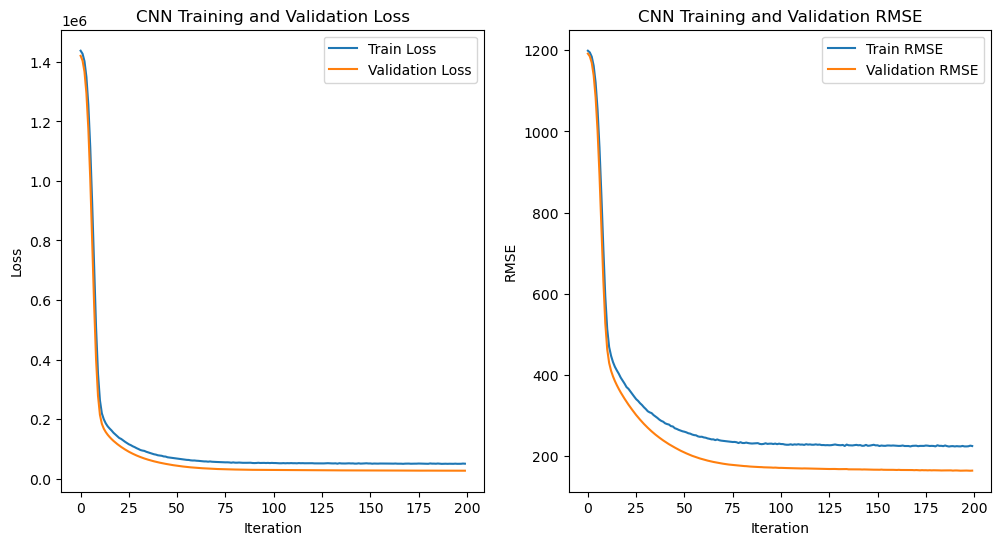

In [14]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('CNN Training and Validation Loss')
plt.legend()

# Plot training and validation RMSE
plt.subplot(1, 2, 2)
plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('CNN Training and Validation RMSE')
plt.legend()

plt.show()

451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


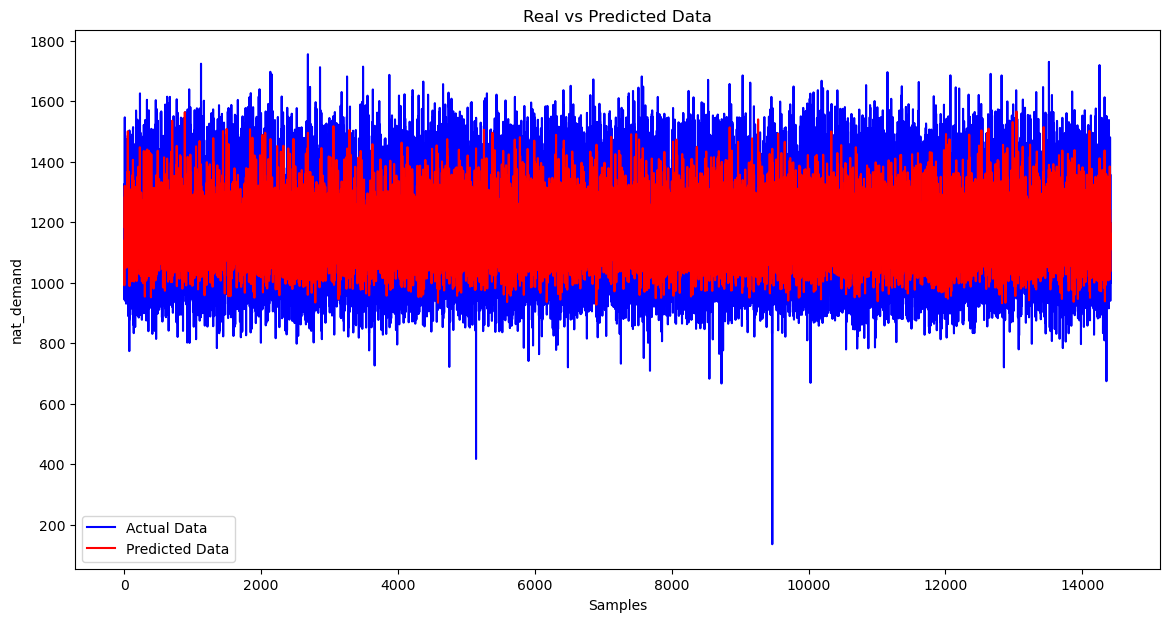

In [15]:
predictions = model.predict([X_test])
plt.figure(figsize=(14, 7))
plt.plot(y_test, color='blue', label='Actual Data')
plt.plot(predictions, color='red', label='Predicted Data')
plt.title('Real vs Predicted Data')
plt.xlabel('Samples')
plt.ylabel('nat_demand')
plt.legend()
plt.show()

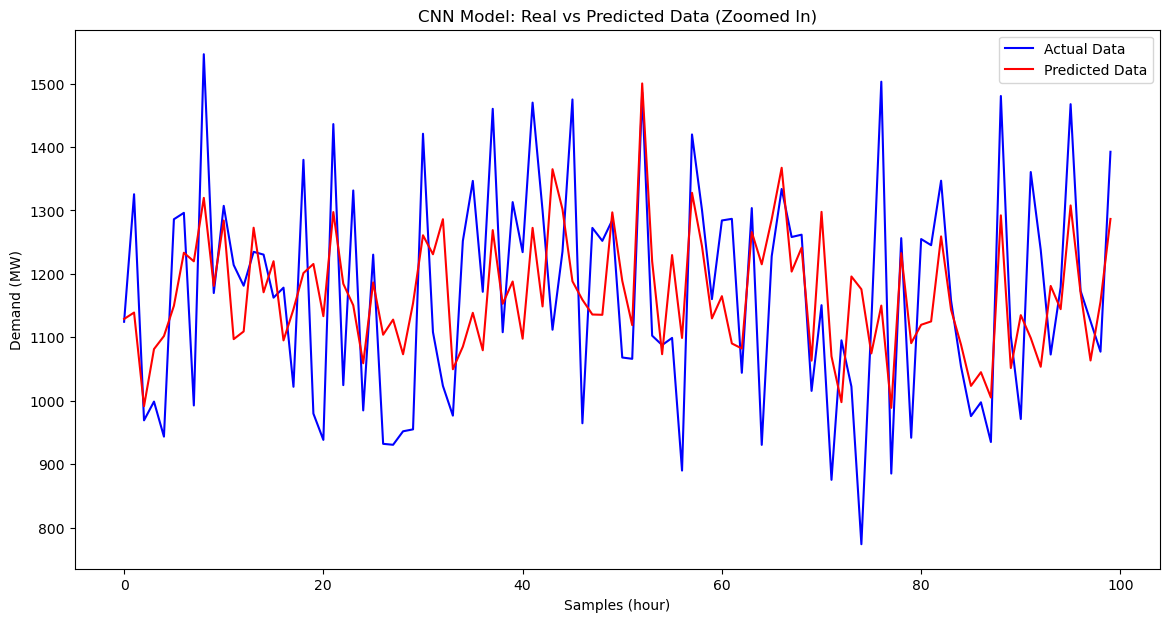

In [16]:
start_sample = 0
end_sample = 100

# Slice the test data and predictions
y_test_zoomed = y_test[start_sample:end_sample]
predictions_zoomed = predictions[start_sample:end_sample]

# Plot the zoomed-in data
plt.figure(figsize=(14, 7))
plt.plot(y_test_zoomed, color='blue', label='Actual Data')
plt.plot(predictions_zoomed, color='red', label='Predicted Data')
plt.title('CNN Model: Real vs Predicted Data (Zoomed In)')
plt.xlabel('Samples (hour)')
plt.ylabel('Demand (MW)')
plt.legend()
plt.show()

In [17]:
model.save('my_cnn_model.h5')

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, GRU, Dense, Dropout, concatenate
from tensorflow.keras.metrics import RootMeanSquaredError
import matplotlib.pyplot as plt

In [19]:
start_time = time.time()  # Record start time

# Select the features and label
features = data_resampled[['QV2M_toc', 'TQL_toc', 'W2M_toc', 'QV2M_san', 'TQL_san', 'W2M_san', 'QV2M_dav', 'TQL_dav', 'W2M_dav','T2M_toc', 'T2M_san', 'T2M_dav', 'datetime']]
labels = data_resampled['nat_demand']

# Convert datetime to numerical values (e.g., timestamp)
features['datetime'] = pd.to_datetime(features['datetime']).astype(int) / 10**9

# Handle missing values
features = features.fillna(method='ffill')

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Prepare data for GRU model (3D shape: samples, timesteps, features)
# Assuming we are treating each row as a separate sample with 1 timestep
X = features_scaled.reshape(features_scaled.shape[0], 1, features_scaled.shape[1])
y = labels.values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build the GRU model
model = Sequential([
    GRU(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError()])

# Train the model
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), batch_size=1440)

# Evaluate the model
loss, rmse = model.evaluate(X_test, y_test)
print(f'Test Loss (MSE): {loss}')
print(f'Test RMSE: {rmse}')

end_time = time.time()  # Record end time

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_67983/1341566383.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['datetime'] = pd.to_datetime(features['datetime']).astype(int) / 10**9
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_67983/1341566383.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='ffill')
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kw

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - loss: 1438832.0000 - root_mean_squared_error: 1199.5129 - val_loss: 1424044.6250 - val_root_mean_squared_error: 1193.3334
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 1435912.1250 - root_mean_squared_error: 1198.2954 - val_loss: 1418278.2500 - val_root_mean_squared_error: 1190.9149
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 1426540.1250 - root_mean_squared_error: 1194.3781 - val_loss: 1404234.8750 - val_root_mean_squared_error: 1185.0042
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1411059.2500 - root_mean_squared_error: 1187.8782 - val_loss: 1374264.2500 - val_root_mean_squared_error: 1172.2902
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1374975.1250 - root_mean_squared_error: 1172.5887 - val_loss: 1318643.0000 - val_root_mean_squared_error: 1148.3218
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1308524.7500 - root_mean_squared_error: 1143.8982 - val_los

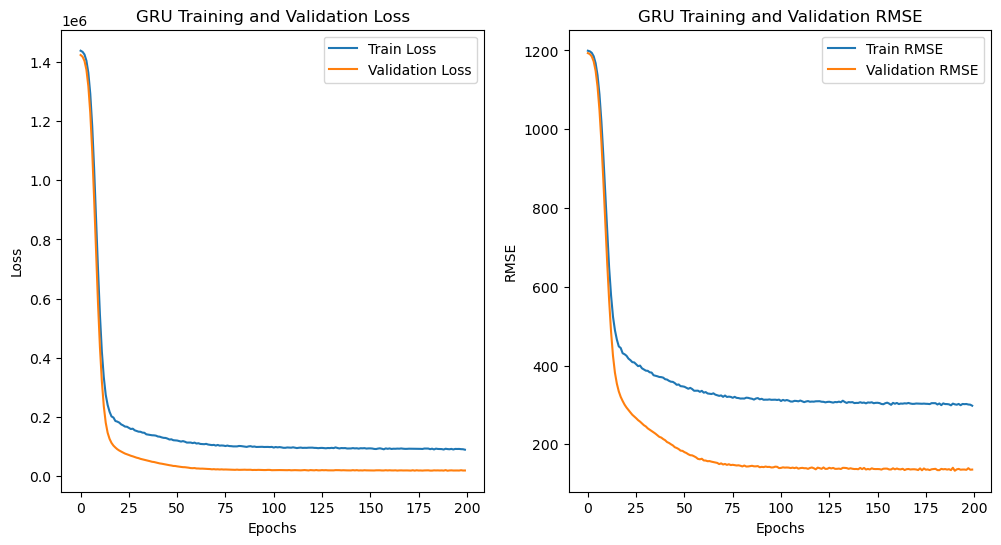

In [20]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GRU Training and Validation Loss')
plt.legend()

# Plot training and validation RMSE
plt.subplot(1, 2, 2)
plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('GRU Training and Validation RMSE')
plt.legend()

plt.show()

451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


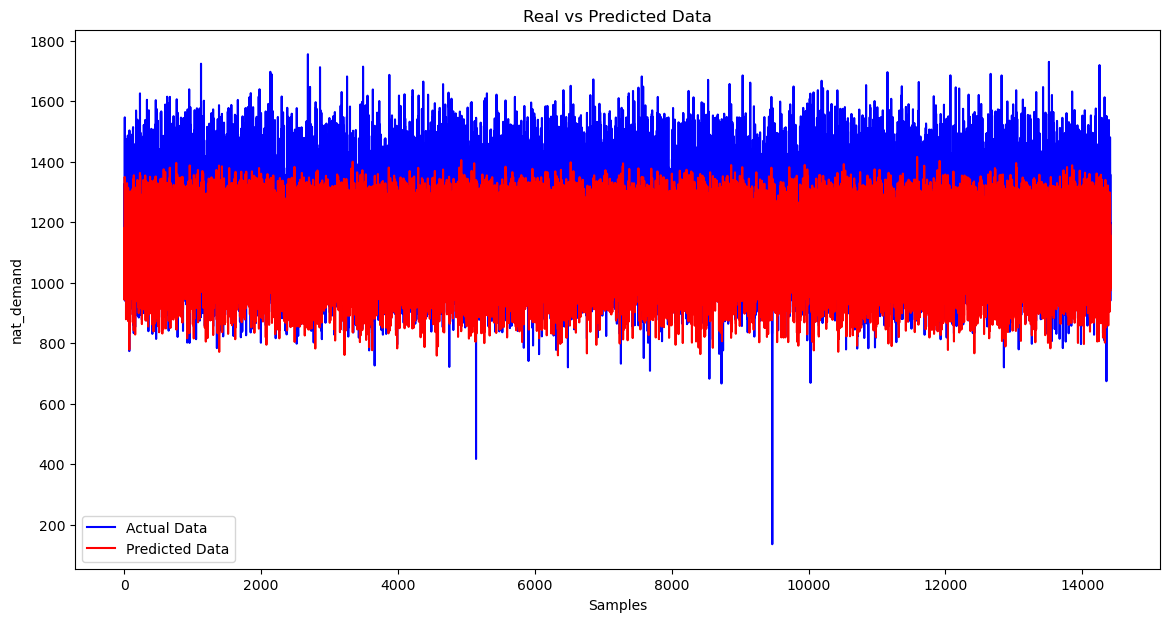

In [21]:
predictions = model.predict([X_test])
plt.figure(figsize=(14, 7))
plt.plot(y_test, color='blue', label='Actual Data')
plt.plot(predictions, color='red', label='Predicted Data')
plt.title('Real vs Predicted Data')
plt.xlabel('Samples')
plt.ylabel('nat_demand')
plt.legend()
plt.show()

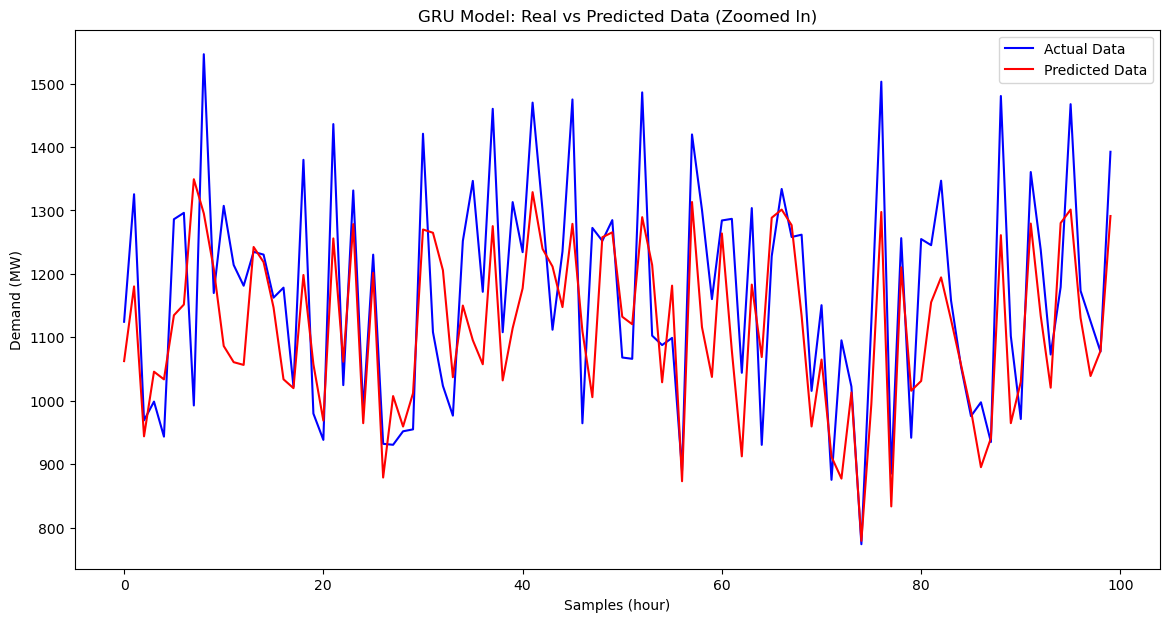

In [22]:
start_sample = 0
end_sample = 100

# Slice the test data and predictions
y_test_zoomed = y_test[start_sample:end_sample]
predictions_zoomed = predictions[start_sample:end_sample]

# Plot the zoomed-in data
plt.figure(figsize=(14, 7))
plt.plot(y_test_zoomed, color='blue', label='Actual Data')
plt.plot(predictions_zoomed, color='red', label='Predicted Data')
plt.title('GRU Model: Real vs Predicted Data (Zoomed In)')
plt.xlabel('Samples (hour)')
plt.ylabel('Demand (MW)')
plt.legend()
plt.show()

In [23]:
model.save('my_gru_model.h5')

In [24]:
start_time = time.time()  # Record start time

# Select the features for CNN and GRU, and label
cnn_features = data_resampled[['QV2M_toc', 'TQL_toc', 'W2M_toc', 'QV2M_san', 'TQL_san', 'W2M_san', 'QV2M_dav', 'TQL_dav', 'W2M_dav', 'datetime']]
gru_features = data_resampled[['QV2M_toc', 'TQL_toc', 'W2M_toc', 'QV2M_san', 'TQL_san', 'W2M_san', 'QV2M_dav', 'TQL_dav', 'W2M_dav','T2M_toc', 'T2M_san', 'T2M_dav', 'datetime']]
labels = data_resampled['nat_demand']

# Convert datetime to numerical values 
cnn_features['datetime'] = pd.to_datetime(cnn_features['datetime']).astype(int) / 10**9
gru_features['datetime'] = pd.to_datetime(gru_features['datetime']).astype(int) / 10**9

# Handle missing values
cnn_features = cnn_features.fillna(method='ffill')
gru_features = gru_features.fillna(method='ffill')

# Scale the features
scaler_cnn = StandardScaler()
cnn_features_scaled = scaler_cnn.fit_transform(cnn_features)

scaler_gru = StandardScaler()
gru_features_scaled = scaler_gru.fit_transform(gru_features)

# Prepare data for CNN 
X_cnn = cnn_features_scaled.reshape(cnn_features_scaled.shape[0], 1, cnn_features_scaled.shape[1])
# Prepare data for GRU 
X_gru = gru_features_scaled.reshape(gru_features_scaled.shape[0], 1, gru_features_scaled.shape[1])
y = labels.values

# Split the data
X_cnn_train, X_cnn_test, X_gru_train, X_gru_test, y_train, y_test = train_test_split(X_cnn, X_gru, y, test_size=0.3, random_state=42)

# Input layers
input_cnn = Input(shape=(X_cnn_train.shape[1], X_cnn_train.shape[2]))
input_gru = Input(shape=(X_gru_train.shape[1], X_gru_train.shape[2]))

# CNN branch
cnn = Conv1D(32, kernel_size=1, activation='relu')(input_cnn)
cnn = MaxPooling1D(pool_size=1)(cnn)
cnn = Conv1D(64, kernel_size=1, activation='relu')(cnn)
cnn = MaxPooling1D(pool_size=1)(cnn)
cnn = Flatten()(cnn)
cnn = Dense(128, activation='relu')(cnn)
# GRU branch
gru = GRU(64, activation='relu', return_sequences=True)(input_gru)
gru = Dropout(0.5)(gru)
gru = GRU(128, activation='relu', return_sequences=True)(gru)
gru = Dropout(0.5)(gru)
gru = GRU(256, activation='relu')(gru)
gru = Dropout(0.5)(gru)

# Concatenate CNN and GRU outputs
concat = concatenate([cnn, gru])

# Fully connected layers
fc = Dense(64, activation='relu')(concat)
fc = Dropout(0.5)(fc)
fc = Dense(32, activation='relu')(fc)
fc = Dropout(0.5)(fc)
output_layer = Dense(1)(fc)

# Build the model
model = Model(inputs=[input_cnn, input_gru], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError()])

# Train the model
history = model.fit([X_cnn_train, X_gru_train], y_train, epochs=200, validation_data=([X_cnn_test, X_gru_test], y_test), batch_size=1440)


end_time = time.time()  # Record end time

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_67983/1370641675.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnn_features['datetime'] = pd.to_datetime(cnn_features['datetime']).astype(int) / 10**9
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_67983/1370641675.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gru_features['datetime'] = pd.to_datetime(gru_features['datetime']).astype(int) / 10**9
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_67983/1370641675.py:

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 291ms/step - loss: 1435146.0000 - root_mean_squared_error: 1197.9752 - val_loss: 1382754.3750 - val_root_mean_squared_error: 1175.9058
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - loss: 1277455.6250 - root_mean_squared_error: 1129.3131 - val_loss: 333860.7500 - val_root_mean_squared_error: 577.8068
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - loss: 402690.8125 - root_mean_squared_error: 634.0024 - val_loss: 131304.5938 - val_root_mean_squared_error: 362.3598
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - loss: 254311.1406 - root_mean_squared_error: 504.2377 - val_loss: 88377.7109 - val_root_mean_squared_error: 297.2839
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - loss: 212532.1719 - root_mean_squared_error: 460.9597 - val_loss: 69805.6250 - val_root_mean_squared_error: 264.2076
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - loss: 188480.4688 - root_mean_squared_error: 434.1204 - val_loss: 60360.847

In [25]:
loss, rmse = model.evaluate([X_cnn_test, X_gru_test], y_test)
print(f'Root Mean Squared Error (RMSE): {rmse}')

451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 21351.3809 - root_mean_squared_error: 146.1070
Root Mean Squared Error (RMSE): 146.5336456298828


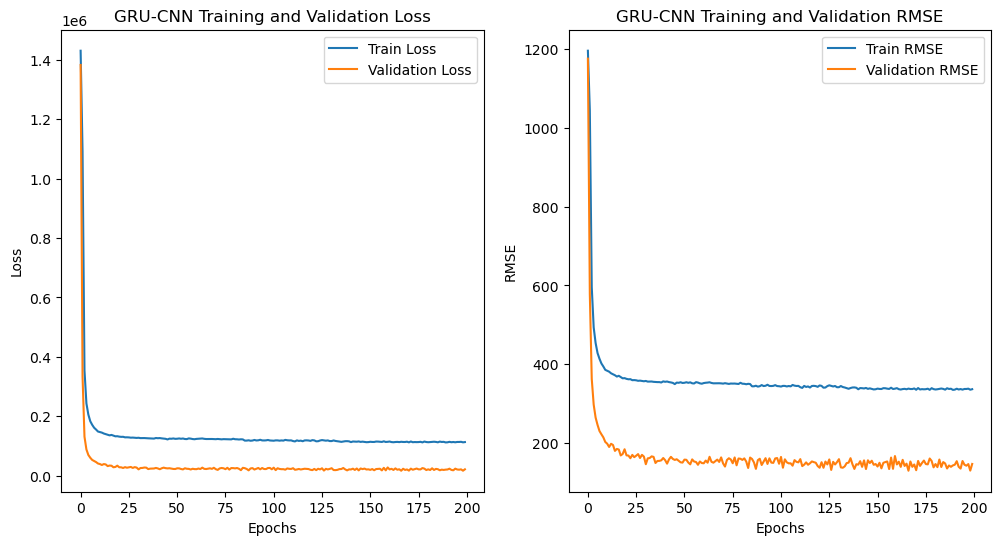

In [26]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GRU-CNN Training and Validation Loss')
plt.legend()

# Plot training and validation RMSE
plt.subplot(1, 2, 2)
plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('GRU-CNN Training and Validation RMSE')
plt.legend()

plt.show()

In [27]:
# Make predictions on the test data
predictions = model.predict([X_cnn_test, X_gru_test])

451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step


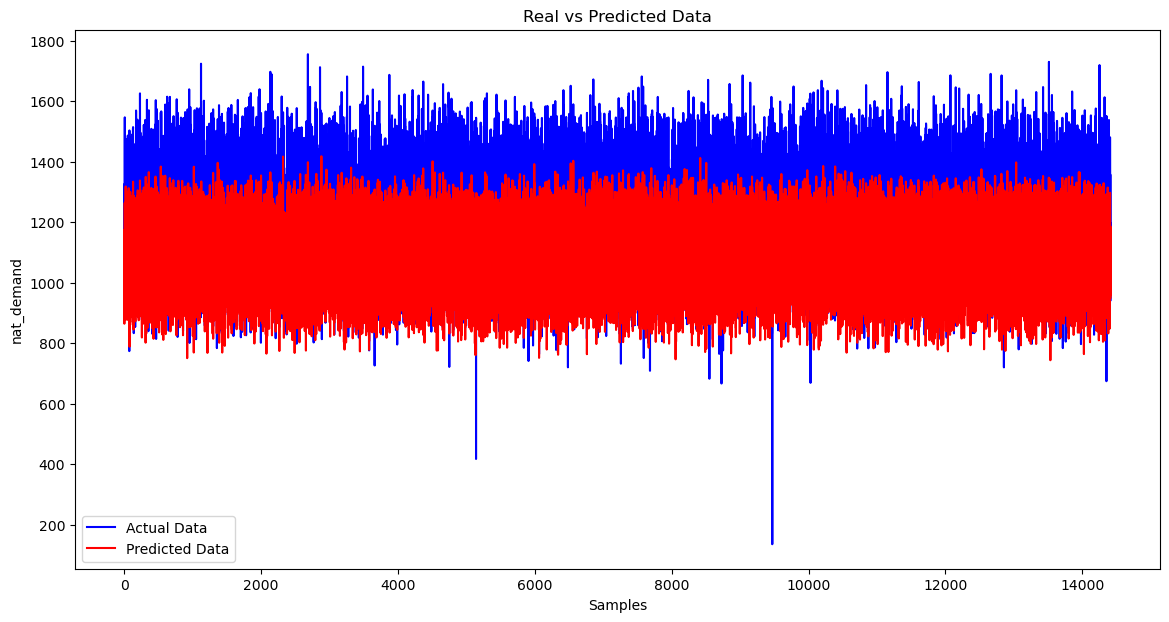

In [28]:
plt.figure(figsize=(14, 7))
plt.plot(y_test, color='blue', label='Actual Data')
plt.plot(predictions, color='red', label='Predicted Data')
plt.title('Real vs Predicted Data')
plt.xlabel('Samples')
plt.ylabel('nat_demand')
plt.legend()
plt.show()

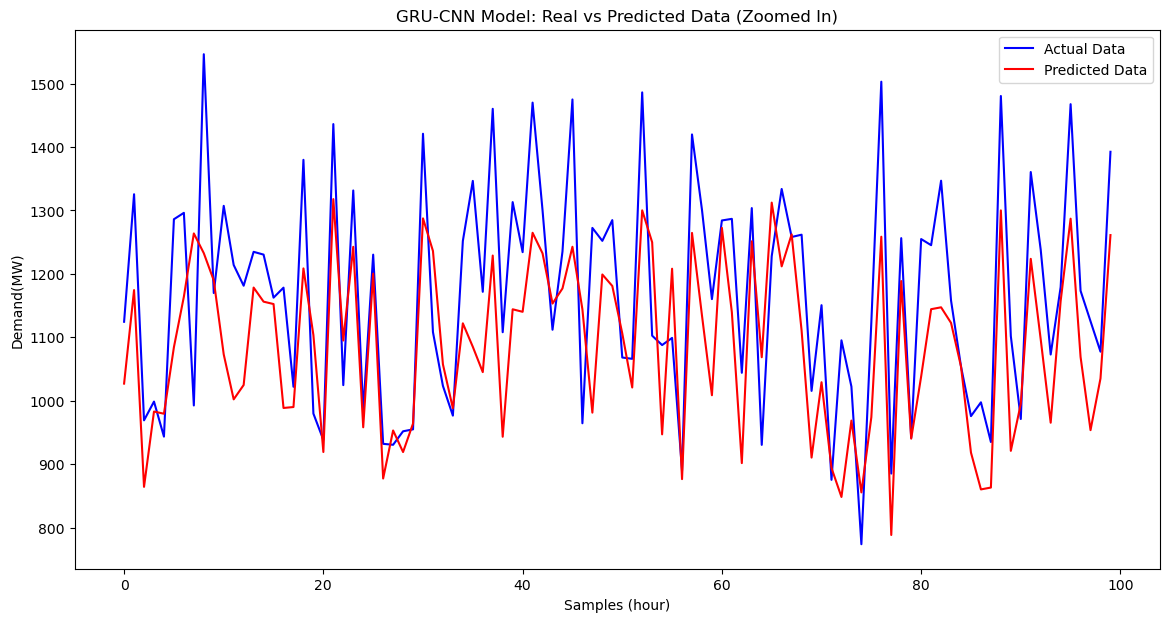

In [29]:
start_sample = 0
end_sample = 100

# Slice the test data and predictions
y_test_zoomed = y_test[start_sample:end_sample]
predictions_zoomed = predictions[start_sample:end_sample]

# Plot the zoomed-in data
plt.figure(figsize=(14, 7))
plt.plot(y_test_zoomed, color='blue', label='Actual Data')
plt.plot(predictions_zoomed, color='red', label='Predicted Data')
plt.title('GRU-CNN Model: Real vs Predicted Data (Zoomed In)')
plt.xlabel('Samples (hour)')
plt.ylabel('Demand(MW)')
plt.legend()
plt.show()

In [30]:
model.save('my_gru_cnn_model.h5')